In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_38/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


# Ensambles - Boosting

A lo largo del notebook vamos a trabajar con el siguiente dataset, que es el que utilizamos en los encuentros anteriores:

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Si ya te sientes seguro/a, puedes utilizar un clasificador AdaBoost de Scikit-Learn sobre este dataset sin seguir los pasos que te dejamos más abajo. También, puedes seguirlos, pero borrando las pistas que te dejamos. ¡Anímate a probar más cosas solo/a!

### Carga de datos

Volvemos a cargas las librerías, importar el dataset y limpiarlo.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics

from sklearn.model_selection import learning_curve

In [3]:
data = pd.read_csv("../Data/weatherAUS.csv.zip")
# Columnas con muchos NaNs
#columnas_descartables = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','RISK_MM','Date']
columnas_descartables = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location', 'Date']
data = data.drop(columns=columnas_descartables)
data = data.dropna()

# Columnas con variables categoricas
columnas_descartables = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']
data = data.drop(columns=columnas_descartables)

# Variables correlacionadas
data = data.drop(columns=['Temp3pm', 'Pressure9am'])

# Mapeo
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1,'No':0})

## 1. AdaBoost

El objetivo de boosting es generar un modelo fuerte a partir de entrenar sucesivamente modelos débiles y combinar sus resultados. La idea es que cada modelo débil que agrego se enfoque en las instancias que fueron clasificadas erroneamente hasta el momento. Empecemos por decidir sobre que fetures del dataset vamos a trabajar (si trabajan sobre 2, luego podrán visualizar):

In [4]:
# Elegimos sobre que coolumnas queremos trabajar

columnas_entrenamiento = ['MaxTemp', 'Humidity3pm']
X = data[columnas_entrenamiento]
y = data.RainTomorrow

# X = data.drop(columns = 'RainTomorrow')
# y = data.RainTomorrow

# Separamos los datos en train y test (held-out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

Recordemos que este tipo de ensamble se enfoca en mejorar el sesgo de los modelos individuales a partir de los cuales está construido, por lo cual se suele usar modelos de alto sesgo y baja varianza.

1. Empiece por importar el clasificador AdaBoostClassifier y el modelo que usaremos como estimador debil, el DecisionTreeClassifier

In [8]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

2. Defina el modelo de manera que utilice 250 árboles de profundidad dos (2). Luego probaremos que sucede para mayores profundidades.Entrene el modelo.

In [12]:
ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth =2), n_estimators=250, learning_rate=1.0, algorithm='SAMME.R', random_state=None,)
ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=250)

3. Calcule el error sobre el training set y sobre el test set. En base a estos resultados, ¿les parece que este ensamble está inclinado hacia el sesgo o hacia la varianza?

In [16]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5 ,shuffle = True,random_state = 42)

acc_train = cross_val_score(ada, X_train, y_train, cv = cv, n_jobs=-1)

acc_train

array([0.82618596, 0.82839975, 0.82952748, 0.82883168, 0.83155165])

In [17]:
acc_train.mean()

0.8288993031095547

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, ada.predict(X_test))

0.8309817580730858

Tiene un accuracy alto tanto en train como en test, diriamos que esta inclinado hacia el lado de tener una alta varianza y bajo sesgo

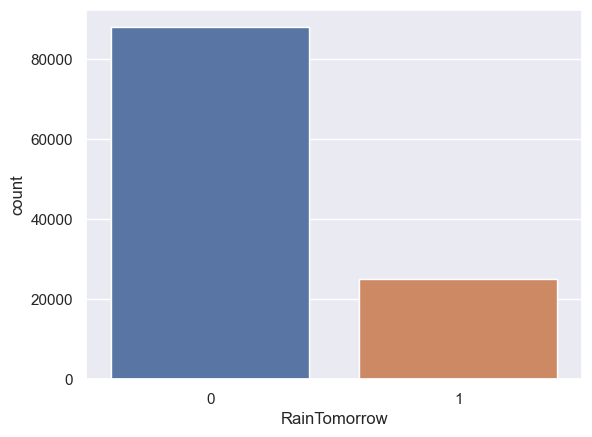

In [23]:
sns.countplot(x=data.RainTomorrow)
plt.show()

Aun asi, la accuracy no es una buena metrica en este dataset, ya que esta desbalanceado

4. Veamos ahora cómo es la distribución de los pesos de cada árbol. Para esto vamos a graficar el número del árbol vs el peso que el algoritmo le está dando para la clasificación final. Además, graficaremos también el accuracy de cada arbol sobre el training set.

Text(0.5, 0, 'Número de árbol')

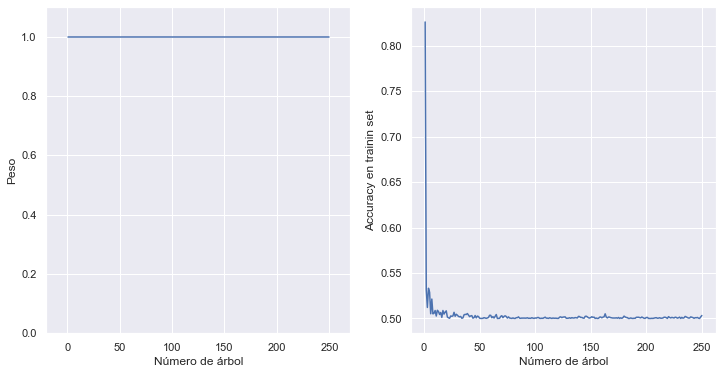

In [26]:
%matplotlib inline
# Puede que el algoritmo termine antes de agregar todos los arboles
# Tomamos entonces la cantidad de arboles que realmente tiene el ensamble
numero_arboles = len(ada)

# En la variable estimator_weights_ esta el peso de cada arbol
pesos = ada.estimator_weights_[:numero_arboles]

# Calculamos el accuracy DE CADA ARBOL en el ensamble. En estimator_errors_ esta el error que comete cada uno.
errores_arboles = ada.estimator_errors_[:numero_arboles]
accuracy_arboles = 1-errores_arboles

# Graficamos
plt.figure(figsize = (12,6))
plt.subplot(121)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' los pesos
plt.plot(range(1, numero_arboles + 1), pesos)
plt.ylabel('Peso')
plt.xlabel('Número de árbol')
plt.ylim((0, pesos.max() * 1.1))
plt.xlim((-20, numero_arboles + 20))
plt.subplot(122)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' el accuracy de cada arbol
plt.plot(range(1, numero_arboles + 1), accuracy_arboles)
plt.ylabel('Accuracy en trainin set')
plt.xlabel('Número de árbol')

5. ¿Le parece relevante la contribución de todos los árboles?¿Cómo se relaciona el accuracy de cada árbol con el peso que le damos en la clasificación final?

6. Veamos cómo cambia el error en el training set y en el test set a medida que agregamos árboles. Para esto vamos a utilizar un metodo llamado `staged_predict`, que nos devuelve la predicción del ensamble en cada instancia en que fuimos agregandole un nuevo estimador.

Text(0.5, 0, 'Número de árboles')

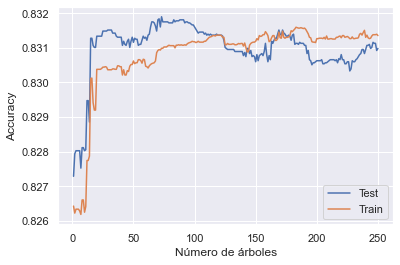

In [27]:
accuracy_test = []
accuracy_train = []
# Calculamos el accuracy sobre el test set
for prediccion_test in ada.staged_predict(X_test):
    accuracy_test.append(metrics.accuracy_score(prediccion_test,y_test))
    
for prediccion_train in ada.staged_predict(X_train):    
    accuracy_train.append(metrics.accuracy_score(prediccion_train,y_train))
    
plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label = 'Test')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_train, label = 'Train')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Número de árboles')

7. Grafiquemos la frontera de decisión del clasificador

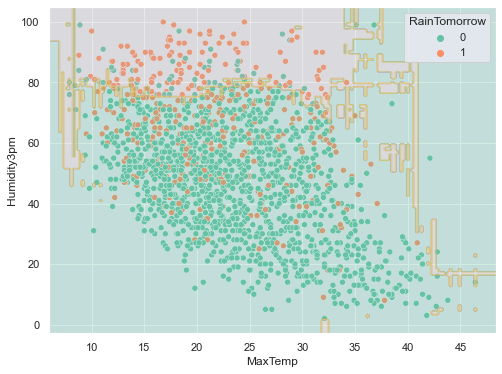

In [29]:
##################
# descometar esto #
##################

N = 20 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))

ax = sns.scatterplot(x = X_test[::N].MaxTemp, y = X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                     np.linspace(*ylim, num=200))
Z = ada.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

8. Repita lo realizado hasta ahora pero utilice árboles de profundidad diez. Preste atención a las curvas de accuracy en train y test y al gráfico de la frontera. ¿Qué le parece que esta sucediendo en este caso?

### 2. XGBoost

Instalar y entrenar un modelo con `XGBoost` sobre este dataset. Explorar diferencias y similitudes con `Adaboost`. 

In [32]:
from catboost import CatBoostClassifier


In [34]:
catb =  CatBoostClassifier().fit(X_train, y_train)

Learning rate set to 0.066578
0:	learn: 0.6500547	total: 77.9ms	remaining: 1m 17s
1:	learn: 0.6133906	total: 97.8ms	remaining: 48.8s
2:	learn: 0.5826387	total: 110ms	remaining: 36.7s
3:	learn: 0.5566313	total: 123ms	remaining: 30.6s
4:	learn: 0.5346785	total: 135ms	remaining: 27s
5:	learn: 0.5163860	total: 147ms	remaining: 24.4s
6:	learn: 0.5010917	total: 160ms	remaining: 22.7s
7:	learn: 0.4872352	total: 176ms	remaining: 21.8s
8:	learn: 0.4760550	total: 190ms	remaining: 21s
9:	learn: 0.4661022	total: 206ms	remaining: 20.4s
10:	learn: 0.4581798	total: 224ms	remaining: 20.1s
11:	learn: 0.4507573	total: 243ms	remaining: 20s
12:	learn: 0.4446993	total: 256ms	remaining: 19.4s
13:	learn: 0.4391920	total: 268ms	remaining: 18.9s
14:	learn: 0.4346324	total: 281ms	remaining: 18.4s
15:	learn: 0.4307010	total: 294ms	remaining: 18.1s
16:	learn: 0.4271745	total: 310ms	remaining: 17.9s
17:	learn: 0.4244195	total: 325ms	remaining: 17.7s
18:	learn: 0.4218275	total: 337ms	remaining: 17.4s
19:	learn: 0.4

In [35]:
accuracy_score(y_test, catb.predict(X_test))

0.8315721116949053